In [1]:
import collections
import cProfile
import hashlib
import itertools
import math
import os
import pstats
import string
import re

from datetime import datetime
from io import StringIO
from tqdm.notebook import tqdm as tqdm

import torch
import torchaudio
from torch import nn, topk
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS, LIBRISPEECH
from torchaudio.transforms import MFCC, Resample

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Empty CUDA cache
torch.cuda.empty_cache()

# Profiling performance
pr = cProfile.Profile()
pr.enable()

In [2]:
audio_backend = "soundfile"
torchaudio.set_audio_backend(audio_backend)

device = "cuda" if torch.cuda.is_available() else "cpu"
num_devices = torch.cuda.device_count()
# num_devices = 1
print(num_devices, "GPUs")

# max number of sentences per batch
# batch_size = 2048
# batch_size = 512
# batch_size = 256
batch_size = 64

training_percentage = 90.
validation_percentage = 5.

data_loader_training_params = {
    "num_workers": 0,
    "pin_memory": True,
    "shuffle": True,
    "drop_last": True,
}
data_loader_validation_params = data_loader_training_params.copy()
data_loader_validation_params["shuffle"] = False

non_blocking = True


# text preprocessing

char_null = "-"
char_space = " "
char_pad = "*"
char_apostrophe = "'"

labels = [char_null + char_pad + char_apostrophe + string.ascii_lowercase]

# excluded_dir = ["_background_noise_"]
# folder_speechcommands = './SpeechCommands/speech_commands_v0.02'
# labels = [char_null, char_pad] + [d for d in next(os.walk(folder_speechcommands))[1] if d not in excluded_dir]


# audio

sample_rate_original = 16000
sample_rate_new = 8000
# resample = Resample(sample_rate_original, sample_rate_new).to(device)
resample = None

n_mfcc = 13
melkwargs = {
    'n_fft': 512,
    'n_mels': 20,
    'hop_length': 80,  # (160, 80)
}
mfcc = MFCC(sample_rate=sample_rate_original, n_mfcc=n_mfcc, melkwargs=melkwargs).to(device)
# mfcc = None


# Optimizer

optimizer_params_adadelta = {
    "lr": 1.0,
    "eps": 1e-8,
    "rho": 0.95,
    "weight_decay": 1e-5,
}

optimizer_params_adam = {
    "lr": .05,
    "eps": 1e-8,
    "weight_decay": .01,
}

optimizer_params_sgd = {
    "lr": .001,
    "weight_decay": .0001,
}

Optimizer = Adadelta
optimizer_params = optimizer_params_adadelta

gamma = 0.95


# Model

num_features = n_mfcc if n_mfcc else 1

lstm_params = {
    "num_layers": 3,
    "batch_first": False,
    "bidirectional": False,
    "dropout": 0.,
}

clip_norm = 0.  # 10.

zero_infinity = False

max_epoch = 200
mod_epoch = 10

dtstamp = datetime.now().strftime("%y%m%d.%H%M%S")
print(dtstamp)

2 GPUs
200315.162920


# Text encoding

In [3]:
class Coder:
    def __init__(self, labels):
        labels = list(collections.OrderedDict.fromkeys(list("".join(labels))))
        self.length = len(labels)
        enumerated = list(enumerate(labels))
        flipped = [(sub[1], sub[0]) for sub in enumerated]

        d1 = collections.OrderedDict(enumerated)
        d2 = collections.OrderedDict(flipped)
        self.mapping = {**d1, **d2}
        self.mapping[char_space] = self.mapping[char_pad]

    def _map(self, iterable):
        # iterable to iterable
        return [self.mapping[i] for i in iterable]

    def encode(self, iterable):
        if isinstance(iterable[0], list):
            return [self.encode(i) for i in iterable]
        else:
            return self._map(iterable)

    def decode(self, tensor):
        if isinstance(tensor[0], list):
            return [self.decode(t) for t in tensor]
        else:
            # not idempotent, since clean string
            return "".join(self._map(tensor)).replace(char_null, "").replace(char_pad, char_space).strip()


coder = Coder(labels)
encode = coder.encode
decode = coder.decode
vocab_size = coder.length
print(vocab_size)

29


# Dataset

In [4]:
class IterableMemoryCache:

    def __init__(self, iterable):
        self.iterable = iterable
        self._iter = iter(iterable)
        self._done = False
        self._values = []

    def __iter__(self):
        if self._done:
            return iter(self._values)
        return itertools.chain(self._values, self._gen_iter())

    def _gen_iter(self):
        for new_values in self._iter:
            self._values.append(new_value)
            yield new_value
        self._done = True

    def __len__(self):
        return len(self._iterable)


class MapMemoryCache(torch.utils.data.Dataset):
    """
    Wrap a dataset so that, whenever a new item is returned, it is saved to memory.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self._cache = [None] * len(dataset)

    def __getitem__(self, n):
        if self._cache[n]:
            return self._cache[n]

        item = self.dataset[n]
        self._cache[n] = item

        return item

    def __len__(self):
        return len(self.dataset)


class Processed(torch.utils.data.Dataset):

    def __init__(self, process_datapoint, dataset):
        self.process_datapoint = process_datapoint
        self.dataset = dataset
        
    def __getitem__(self, n):
        try:
            item = self.dataset[n]
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return None

    def __next__(self):
        try:
            item = next(self.dataset)
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return self.__next__()
        
    def __len__(self):
        return len(self.dataset)

In [5]:
# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2].lower().replace(char_space, char_pad)

    # apply mfcc, tranpose for pad_sequence
    if resample is not None:
        transformed = resample(transformed)
    
    if mfcc is not None:
        transformed = mfcc(transformed)
    else:
        transformed = transformed.unsqueeze(1)
    
    transformed = transformed[0, ...].transpose(0, -1)
    
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)

    transformed = transformed.to("cpu")
    target = target.to("cpu")
    return transformed, target

In [6]:
def datasets():

    root = "./"
    def create(tag):
        data = LIBRISPEECH(root, tag, download=True)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("train-clean-100"), create("dev-clean"), None


training, validation, _ = datasets()

In [7]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """
    
    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

    base_name = os.path.basename(filename)

    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode("utf-8")
    
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))
    
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'

    return result


def filter_speechcommands(tag, training_percentage, data):
    if training_percentage < 100.:
            testing_percentage = (100. - training_percentage - validation_percentage)
            which_set_filter = lambda x: which_set(x, validation_percentage, testing_percentage) == tag
            data._walker = list(filter(which_set_filter, data._walker))
    return data


def datasets():

    root = "./"
    def create(tag):
        data = SPEECHCOMMANDS(root, download=True)
        data = filter_speechcommands(tag, training_percentage, data)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("training"), create("validation"), create("testing")


# training, validation, _ = datasets()

In [8]:
def collate_fn(batch):

    tensors = [b[0] for b in batch if b]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)

    targets = [b[1] for b in batch if b]
    target_lengths = torch.tensor(
        [target.shape[0] for target in targets], dtype=torch.long, device=tensors.device
    )
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

    # print(targets.shape)
    # print(decode(targets.tolist()))
    
    return tensors, targets, target_lengths

# Model

[Wav2Letter](https://github.com/LearnedVector/Wav2Letter/blob/master/Google%20Speech%20Command%20Example.ipynb)

In [9]:
def weight_init(m): 
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = math.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)


class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x)
        return x
    

class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or power spectrums speech signals

        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self, num_features, num_classes):
        super().__init__()

        # Conv1d(in_channels, out_channels, kernel_size, stride)
        self.layers = nn.Sequential(
            nn.Conv1d(num_features, 250, 48, 2),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            nn.Conv1d(250, 2000, 32),
            nn.ReLU(),
            nn.Conv1d(2000, 2000, 1),
            nn.ReLU(),
            nn.Conv1d(2000, num_classes, 1),
        )

    def forward(self, batch):
        """Forward pass through Wav2Letter network than
            takes log probability of output
        Args:
            batch (int): mini batch of data
            shape (batch, num_features, frame_len)
        Returns:
            Tensor with shape (batch_size, num_classes, output_len)
        """
        # batch: (batch_size, num_features, seq_len)
        y_pred = self.layers(batch)
        # y_pred: (batch_size, num_classes, output_len)
        y_pred = y_pred.transpose(-1, -2)
        # y_pred: (batch_size, output_len, num_classes)
        return nn.functional.log_softmax(y_pred, dim=-1)    

In [10]:
class LSTMModel(nn.Module):

    def __init__(self, num_features, num_classes, num_layers, bidirectional, dropout, batch_first):
        super().__init__()
        
        directions = bidirectional + 1

        self.layer = nn.LSTM(
            num_features, num_classes,
            num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=batch_first
        )
        # self.hidden2class = nn.Linear(directions*num_classes, num_classes)

    def forward(self, batch):
        # self.layer.flatten_parameters()
        # print("forward")
        # batch: batch, num_features, seq_len
        # print(batch.shape)
        batch = batch.transpose(-1, -2).contiguous()
        # batch: batch, seq_len, num_features
        # print(batch.shape)
        outputs, _ = self.layer(batch)
        # outputs: batch, seq_len, directions*num_features
        # outputs = self.hidden2class(outputs)
        # outputs: batch, seq_len, num_features
        # print(outputs.shape)
        return nn.functional.log_softmax(outputs, dim=-1)    

# Word Decoder

In [11]:
def greedy_decoder(outputs):
    """Greedy Decoder. Returns highest probability of class labels for each timestep

    Args:
        outputs (torch.Tensor): shape (input length, batch size, number of classes (including blank))

    Returns:
        torch.Tensor: class labels per time step.
    """
    _, indices = topk(outputs, k=1, dim=-1)
    return indices[..., 0]

In [141]:
from collections import Counter

a = "aaabca"

# Count bigrams
c = Counter(["".join(z) for z in zip(a, a[1:])])

# Encode as transition matrix
c = [(encode(k),v) for k,v in c.items()]

ind = torch.tensor(list(zip(*[a for (a,b) in c])))
val = torch.tensor([b for (a,b) in c])

torch.sparse_coo_tensor(indices=ind, values=val, size=[6,6]).to_dense()

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0]])

In [35]:
from collections import Counter

c = None

for _, label in training:
    # Count bigrams
    count = [((a.item(), b.item())) for (a,b) in zip(label, label[1:])]
    count = Counter(count)
    if c is None:
        c = count
    else:
        c = c + count

# Encode as transition matrix

ind = torch.tensor(list(zip(*[a for (a,b) in c.items()])))
val = torch.tensor([b for (a,b) in c.items()], dtype=torch.float)

transitions = torch.sparse_coo_tensor(indices=ind, values=val, size=[vocab_size,vocab_size]).coalesce().to_dense()
transitions = (transitions/torch.max(torch.tensor(1.), transitions.max(dim=1)[0]).unsqueeze(1))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0211e-01, 2.8820e-01, 2.5007e-01,
         1.8370e-01, 1.3226e-01, 2.4586e-01, 1.2155e-01, 4.6970e-01, 4.0684e-01,
         2.8625e-02, 3.8320e-02, 1.6229e-01, 2.8148e-01, 1.4473e-01, 4.0300e-01,
         1.8928e-01, 1.3971e-02, 1.3583e-01, 4.6050e-01, 1.0000e+00, 7.1878e-02,
         4.0488e-02, 4.5780e-01, 4.5979e-05, 8.6414e-02, 9.9183e-04],
        [0.0000e+00, 2.7440e-03, 0.0000e+00, 2.4500e-02, 1.7640e-03, 2.1756e-02,
         7.8205e-02, 6.6641e-03, 5.8800e-04, 0.0000e+00, 7.8401e-04, 9.8001e-04,
         0.0000e+00, 1.9600e-04, 1.1133e-01, 7.781

In [72]:
# https://gist.github.com/PetrochukM/afaa3613a99a8e7213d2efdd02ae4762
# https://github.com/napsternxg/pytorch-practice/blob/master/Viterbi%20decoding%20and%20CRF.ipynb

def viterbi_decode(tag_sequence: torch.Tensor, transition_matrix: torch.Tensor, top_k: int=5):
    """
    Perform Viterbi decoding in log space over a sequence given a transition matrix
    specifying pairwise (transition) potentials between tags and a matrix of shape
    (sequence_length, num_tags) specifying unary potentials for possible tags per
    timestep.
    Parameters
    ----------
    tag_sequence : torch.Tensor, required.
        A tensor of shape (sequence_length, num_tags) representing scores for
        a set of tags over a given sequence.
    transition_matrix : torch.Tensor, required.
        A tensor of shape (num_tags, num_tags) representing the binary potentials
        for transitioning between a given pair of tags.
    top_k : int, required.
        Integer defining the top number of paths to decode.
    Returns
    -------
    viterbi_path : List[int]
        The tag indices of the maximum likelihood tag sequence.
    viterbi_score : float
        The score of the viterbi path.
    """
    sequence_length, num_tags = list(tag_sequence.size())

    path_scores = []
    path_indices = []
    # At the beginning, the maximum number of permutations is 1; therefore, we unsqueeze(0)
    # to allow for 1 permutation.
    path_scores.append(tag_sequence[0, :].unsqueeze(0))
    # assert path_scores[0].size() == (n_permutations, num_tags)

    # Evaluate the scores for all possible paths.
    for timestep in range(1, sequence_length):
        # Add pairwise potentials to current scores.
        # assert path_scores[timestep - 1].size() == (n_permutations, num_tags)
        summed_potentials = path_scores[timestep - 1].unsqueeze(2) + transition_matrix
        summed_potentials = summed_potentials.view(-1, num_tags)

        # Best pairwise potential path score from the previous timestep. 
        max_k = min(summed_potentials.size()[0], top_k)
        scores, paths = torch.topk(summed_potentials, k=max_k, dim=0)
        # assert scores.size() == (n_permutations, num_tags)
        # assert paths.size() == (n_permutations, num_tags)

        scores = tag_sequence[timestep, :] + scores
        # assert scores.size() == (n_permutations, num_tags)
        path_scores.append(scores)
        path_indices.append(paths.squeeze())

    # Construct the most likely sequence backwards.
    path_scores = path_scores[-1].view(-1)
    max_k = min(path_scores.size()[0], top_k)
    viterbi_scores, best_paths = torch.topk(path_scores, k=max_k, dim=0)
    viterbi_paths = []
    for i in range(max_k):
        viterbi_path = [best_paths[i]]
        for backward_timestep in reversed(path_indices):
            viterbi_path.append(int(backward_timestep.view(-1)[viterbi_path[-1]]))
        # Reverse the backward path.
        viterbi_path.reverse()
        # Viterbi paths uses (num_tags * n_permutations) nodes; therefore, we need to modulo.
        viterbi_path = [j % num_tags for j in viterbi_path]
        viterbi_paths.append(viterbi_path)
    return viterbi_paths, viterbi_scores

In [67]:
# https://martin-thoma.com/word-error-rate-calculation/

def compute_wer(r, h):
    """
    Calculation of WER with Levenshtein distance.
    """

    # initialisation
    # import numpy
    # d = numpy.zeros((len(r)+1, len(h)+1), dtype=numpy.uint8)
    # d[0,:] = range(len(h)+1)
    # d[:,0] = range(len(r)+1)
    
    # initialisation
    d = torch.zeros((len(r)+1, len(h)+1), dtype=torch.long)
    d[0,:] = torch.range(0,len(h), dtype=torch.long)
    d[:,0] = torch.range(0,len(r), dtype=torch.long)

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                substitution = d[i-1,j-1] + 1
                insertion    = d[i,j-1] + 1
                deletion     = d[i-1,j] + 1
                d[i,j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)].item()/len(r)

# Train

In [13]:
loader_training = DataLoader(
    training, batch_size=batch_size, collate_fn=collate_fn, **data_loader_training_params
)

loader_validation = DataLoader(
    validation, batch_size=batch_size, collate_fn=collate_fn, **data_loader_validation_params
)

print(len(loader_training), len(loader_validation))

# num_features = next(iter(loader_training))[0].shape[1]
# print(num_features)

445 42


In [14]:
model = Wav2Letter(num_features, vocab_size)
# model = LSTMModel(num_features, vocab_size, **lstm_params)

model = torch.jit.script(model)
model = nn.DataParallel(model) if num_devices > 1 else model
model = model.to(device, non_blocking=non_blocking)
# model.apply(weight_init)

optimizer = Optimizer(model.parameters(), **optimizer_params)
# scheduler = ExponentialLR(optimizer, gamma=gamma)
# scheduler = ReduceLROnPlateau(optimizer)

criterion = torch.nn.CTCLoss(zero_infinity=zero_infinity)
# criterion = nn.MSELoss()
# criterion = torch.nn.NLLLoss()

best_loss = 1.

In [15]:
def forward_and_loss(inputs, targets, target_lengths):

    inputs = inputs.to(device, non_blocking=non_blocking)
    targets = targets.to(device, non_blocking=non_blocking)
    
    # keep batch first for data parallel
    outputs = model(inputs).transpose(0, 1)

    this_batch_size = outputs.shape[1]
    seq_len = outputs.shape[0]
    input_lengths = torch.full((this_batch_size,), seq_len, dtype=torch.long, device=outputs.device)
    
    # CTC    
    # outputs: input length, batch size, number of classes (including blank)
    # targets: batch size, max target length
    # input_lengths: batch size
    # target_lengths: batch size

    return criterion(outputs, targets, input_lengths, target_lengths)


def forward_decode_wer(inputs, targets):

    import statistics
    
    output = model(inputs)

    # output = output[0, :, :].unsqueeze(0)
    # targets = targets[0, ...].unsqueeze(0)

    # output = output.transpose(0, 1)
    output = greedy_decoder(output)

    output = decode(output.tolist())
    target = decode(targets.tolist())
    
    print_length = 20
    output_print = output[0].ljust(print_length)[:print_length]
    target_print = target[0].ljust(print_length)[:print_length]
    print(f"Epoch: {epoch:4}   Target: {target_print}   Output: {output_print}")

    output = [o.split(char_space) for o in output]
    target = [o.split(char_space) for o in target]
    
    wers = [compute_wer(a, b) for a, b in zip(output, target)]
    score = statistics.mean(wers)
    # score = statistics.median(wers)
    print(f"Epoch: {epoch:4}   WER: {score:1.5f}")

    return score

In [16]:
sum_loss_training = []
sum_loss_validation = []
gradient_norm = []
gradient_norm_training = []
wer_validation = []

with tqdm(total=max_epoch, unit_scale=1) as pbar:
    for epoch in range(max_epoch):
        model.train()

        sum_loss = 0.
        for inputs, targets, target_lengths in loader_training:

            loss = forward_and_loss(inputs, targets, target_lengths)
            sum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            if clip_norm > 0:
                total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                gradient_norm_training.append((epoch, total_norm))
                print(f"Epoch: {epoch:4}   Gradient: {total_norm:4.5f}")
            optimizer.step()

            pbar.update(1/len(loader_training))

        # Average loss
        sum_loss = sum_loss / len(loader_training)
        sum_loss_training.append((epoch, sum_loss))
        sum_loss_str = f"Epoch: {epoch:4}   Train: {sum_loss:4.5f}"
        
        # scheduler.step()
        # scheduler.step(sum_loss)
        
        with torch.no_grad():

            if not epoch % mod_epoch or epoch == max_epoch-1:

                total_norm = 0.
                for p in list(filter(lambda p: p.grad is not None, model.parameters())):
                    total_norm += p.grad.data.norm(2).item() ** 2                    
                total_norm = total_norm ** (1. / 2)
                gradient_norm.append(total_norm)
                print(f"Epoch: {epoch:4}   Gradient: {total_norm}")
                
                # Switch to evaluation mode
                model.eval()
        
                sum_loss = 0.
                for inputs, targets, target_lengths in loader_validation:
                    sum_loss += forward_and_loss(inputs, targets, target_lengths).item()

                # Average loss
                sum_loss = sum_loss / len(loader_validation)
                sum_loss_validation.append((epoch, sum_loss))
                sum_loss_str += f"   Validation: {sum_loss:.5f}"

                wer = forward_decode_wer(inputs, targets)
                wer_validation.append((epoch, wer))

                print(sum_loss_str)

                if sum_loss < best_loss:
                    # Save model
                    torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")
                    best_loss = sum_loss


Epoch:    0   Gradient: 1.9691160315727263
Epoch:    0   Target: we will hunt wolves    Output:                     
Epoch:    0   WER: 21.21875
Epoch:    0   Train: 3.70042   Validation: 2.96873


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   10   Gradient: 1.9157189685401814
Epoch:   10   Target: we will hunt wolves    Output: welehunmolse  the co
Epoch:   10   WER: 0.94321
Epoch:   10   Train: 0.78294   Validation: 0.89691


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   30   Gradient: 1.2472710668181826
Epoch:   30   Target: we will hunt wolves    Output: wili  hhunt mols the
Epoch:   30   WER: 0.89873
Epoch:   30   Train: 0.16472   Validation: 1.19151


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:   60   Gradient: 1.5137953036347327
Epoch:   60   Target: we will hunt wolves    Output: whiilia hhunt mollee
Epoch:   60   WER: 0.93410
Epoch:   60   Train: 0.04511   Validation: 2.10709


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   70   Gradient: 0.8359894537585131
Epoch:   70   Target: we will hunt wolves    Output: willhhunt boles the 
Epoch:   70   WER: 0.92354
Epoch:   70   Train: 0.03829   Validation: 2.18692


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:  100   Gradient: 2.386884791298679
Epoch:  100   Target: we will hunt wolves    Output: liilhhunn olles the 
Epoch:  100   WER: 0.92445
Epoch:  100   Train: 0.02705   Validation: 2.41518


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:  110   Gradient: 0.9284177462004661
Epoch:  110   Target: we will hunt wolves    Output: whit  lhhunnnollees 
Epoch:  110   WER: 0.93705
Epoch:  110   Train: 0.02484   Validation: 2.43363


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:  140   Gradient: 0.8091099427005691
Epoch:  140   Target: we will hunt wolves    Output: willl hhunt  wolles 
Epoch:  140   WER: 0.93062
Epoch:  140   Train: 0.01922   Validation: 2.50753


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:  170   Gradient: 0.6786116151947998
Epoch:  170   Target: we will hunt wolves    Output: wi' hhunk oles the  
Epoch:  170   WER: 0.92811
Epoch:  170   Train: 0.01751   Validation: 2.50675


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:  190   Gradient: 0.6649078845399577
Epoch:  190   Target: we will hunt wolves    Output: wi'ill hunwolles the
Epoch:  190   WER: 0.91573
Epoch:  190   Train: 0.01571   Validation: 2.55924


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:  199   Gradient: 0.8413622720888496
Epoch:  199   Target: we will hunt wolves    Output: wiil hun molles the 
Epoch:  199   WER: 0.92344
Epoch:  199   Train: 0.01665   Validation: 2.52914



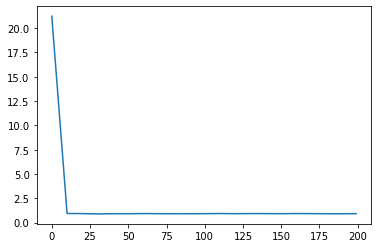

In [17]:
plt.plot(*zip(*wer_validation))

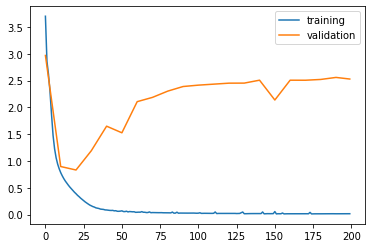

In [18]:
plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()

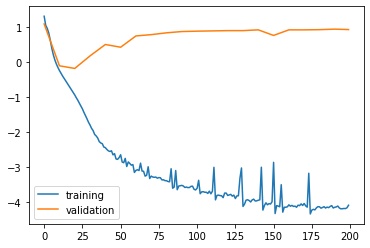

In [19]:
sum_loss_training = [(a, math.log(b)) for (a,b) in sum_loss_training]
sum_loss_validation = [(a, math.log(b)) for (a,b) in sum_loss_validation]

plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()

In [20]:
# print(torch.cuda.memory_summary())

In [21]:
# Save model
torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")

# Print performance
pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(20)
print(s.getvalue())

         939883672 function calls (904098273 primitive calls) in 71437.558 seconds

   Ordered by: cumulative time
   List reduced from 2659 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        7    0.000    0.000 71437.555 10205.365 base_events.py:1686(_run_once)
      115    0.000    0.000 71437.555  621.196 events.py:86(_run)
      115    0.000    0.000 71437.555  621.196 {method 'run' of 'Context' objects}
       88    0.000    0.000 71437.555  811.790 ioloop.py:735(_run_callback)
     63/7    0.001    0.000 71437.555 10205.365 gen.py:716(run)
   100/27    0.000    0.000 71437.554 2645.835 {method 'send' of 'generator' objects}
        5    0.000    0.000 71437.552 14287.510 ioloop.py:690(<lambda>)
        5    0.000    0.000 71437.552 14287.510 gen.py:784(inner)
    80/22    0.001    0.000 71437.550 3247.161 gen.py:184(wrapper)
       60    0.000    0.000 71437.549 1190.626 kernelbase.py:347(process_one)
       40    0.001 